## Load everything

In [1]:
import yaml
import sys
import traceback
import logging
import contextlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import sympy

%matplotlib inline

from tqdm.notebook import tqdm
from typing import *

%load_ext autoreload
%autoreload 2

import os
current_dir = os.getcwd()
os.chdir("../src")
from dqnroute import *
os.chdir(current_dir)

logger = logging.getLogger(DQNROUTE_LOGGER)
TORCH_MODELS_DIR = '../torch_models'
LOG_DATA_DIR = '../logs/runs'
np.set_printoptions(linewidth=500)

_legend_txt_replace = {
    'networks': {
        'link_state': 'Shortest paths', 'simple_q': 'Q-routing', 'pred_q': 'PQ-routing',
        'glob_dyn': 'Global-dynamic', 'dqn': 'DQN', 'dqn_oneout': 'DQN (1-out)',
        'dqn_emb': 'DQN-LE', 'centralized_simple': 'Centralized control'
    },
    'conveyors': {
        'link_state': 'Vyatkin-Black', 'simple_q': 'Q-routing', 'pred_q': 'PQ-routing',
        'glob_dyn': 'Global-dynamic', 'dqn': 'DQN', 'dqn_oneout': 'DQN (1-out)',
        'dqn_emb': 'DQN-LE', 'centralized_simple': 'BSR'
    }
}
_targets = {'time': 'avg','energy': 'sum', 'collisions': 'sum'}
_ylabels = {
    'time': 'Mean delivery time', 'energy': 'Total energy consumption', 'collisions': 'Cargo collisions'
}

def print_sums(df):
    types = set(df['router_type'])
    for tp in types:
        x = df.loc[df['router_type']==tp, 'count'].sum()
        txt = _legend_txt_replace.get(tp, tp)
        print('  {}: {}'.format(txt, x))

def plot_data(data, meaning='time', figsize=(15,5), xlim=None, ylim=None, xlabel='Simulation time',
              ylabel=None, font_size=14, title=None, save_path=None, draw_collisions=False,
              context='networks', **kwargs):
    if 'time' not in data.columns:
        datas = split_dataframe(data, preserved_cols=['router_type', 'seed'])
        for tag, df in datas:
            if tag == 'collisions' and not draw_collisions:
                print('Number of collisions:')
                print_sums(df)
                continue
                
            xlim = kwargs.get(tag+'_xlim', xlim)
            ylim = kwargs.get(tag+'_ylim', ylim)
            save_path = kwargs.get(tag+'_save_path', save_path)
            plot_data(df, meaning=tag, figsize=figsize, xlim=xlim, ylim=ylim,
                      xlabel=xlabel, ylabel=ylabel, font_size=font_size,
                      title=title, save_path=save_path, context='conveyors')
        return 
    
    target = _targets[meaning]
    if ylabel is None:
        ylabel = _ylabels[meaning]
        
    fig = plt.figure(figsize=figsize)
    ax = sns.lineplot(x='time', y=target, hue='router_type', data=data,
                      err_kws={'alpha': 0.1})
    
    handles, labels = ax.get_legend_handles_labels()
    new_labels = list(map(lambda l: _legend_txt_replace[context].get(l, l), labels[1:]))
    ax.legend(handles=handles[1:], labels=new_labels, fontsize=font_size)
    
    ax.tick_params(axis='both', which='both', labelsize=int(font_size*0.75))
        
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    if title is not None:
        ax.set_title(title)
    
    ax.set_xlabel(xlabel, fontsize=font_size)
    ax.set_ylabel(ylabel, fontsize=font_size)
    
    plt.show(fig)
    
    if save_path is not None:
        fig.savefig('../img/' + save_path, bbox_inches='tight')

def split_data(dct):
    results = []
    
    def add_res(i, key, val):
        while len(results) <= i:
            results.append({})
        results[i][key] = val
    
    for (key, vals) in dct.items():
        for (i, val) in enumerate(vals):
            add_res(i, key, val)
    return tuple(results)
    
def combine_launch_data(launch_data):
    dfs = []
    for (job_id, data) in launch_data.items():
        router_type, seed = un_job_id(job_id)
        df = data.copy()
        add_cols(df, router_type=router_type, seed=seed)
        dfs.append(df)
    return pd.concat(dfs, axis=0)

class DummyTqdmFile(object):
    """Dummy file-like that will write to tqdm"""
    file = None
    def __init__(self, file):
        self.file = file

    def write(self, x):
        # Avoid print() second call (useless \n)
        if len(x.rstrip()) > 0:
            tqdm.write(x, file=self.file)

    def flush(self):
        return getattr(self.file, "flush", lambda: None)()

@contextlib.contextmanager
def std_out_err_redirect_tqdm():
    orig_out_err = sys.stdout, sys.stderr
    try:
        sys.stdout, sys.stderr = map(DummyTqdmFile, orig_out_err)
        yield orig_out_err[0]
    # Relay exceptions
    except Exception as exc:
        raise exc
    # Always restore sys.stdout/err if necessary
    finally:
        sys.stdout, sys.stderr = orig_out_err

## Run simulation

In [2]:
def run_single(file: str, router_type: str, random_seed: int, **kwargs):
    job_id = mk_job_id(router_type, random_seed)
    with tqdm(desc=job_id) as bar:
        queue = DummyProgressbarQueue(bar)
        runner = ConveyorsRunner(run_params=file, router_type=router_type,
                                 random_seed=random_seed, progress_queue=queue, **kwargs)
        event_series = runner.run(**kwargs)
    return event_series, runner

#scenario, emb_dim, graph_size = '../launches/igor/acyclic_conveyor_energy_test.yaml', 10, 20
scenario, emb_dim, graph_size = '../launches/igor/conveyor_cyclic_energy_test.yaml', 5, 8
#scenario, emb_dim, graph_size = '../launches/igor/conveyor_cyclic2_energy_test.yaml', 5, 16
#scenario, emb_dim, graph_size = '../launches/igor/tarau2010.yaml', 8, 27
#scenario, emb_dim, graph_size = '../launches/igor/johnstone2010.yaml', 12, 54

os.environ["IGOR_OVERRIDDEN_DQN_LOAD_FILENAME"] = \
    f"igor_trained_{emb_dim}_{graph_size}_{os.path.split(scenario)[1]}.bin"

# 'link_state', 'simple_q', 'dqn_emb'
router_type='dqn_emb'
#router_type='link_state'

event_series, runner = run_single(file=scenario, router_type=router_type, progress_step=500,
                                  ignore_saved=[True], random_seed=44)

## Explore the graph

In [3]:
from dqnroute.verification.router_graph import RouterGraph
g = RouterGraph(runner.world)
print("Reachability matrix:")
g.print_reachability_matrix()

Graph size = 8
conveyor 0: [(('sourcing_diverter', 0), 0)], length = 20
conveyor 1: [(('junction', 3), 0), (('junction', 4), 20)], length = 40
conveyor 2: [(('junction', 0), 0)], length = 20
conveyor 3: [(('junction', 1), 0), (('diverter', 0), 20)], length = 40
conveyor 4: [(('junction', 2), 0)], length = 20
conveyor 5: [(('source', 0), 0)], length = 20
Reachability matrix:
11111111 # from ('source', 0)
01111111 # from ('diverter', 0)
01111111 # from ('junction', 0)
01111111 # from ('junction', 1)
01111111 # from ('junction', 2)
01111111 # from ('junction', 3)
01111111 # from ('junction', 4)
00000001 # from ('sink', 0)


## Visualize the graph

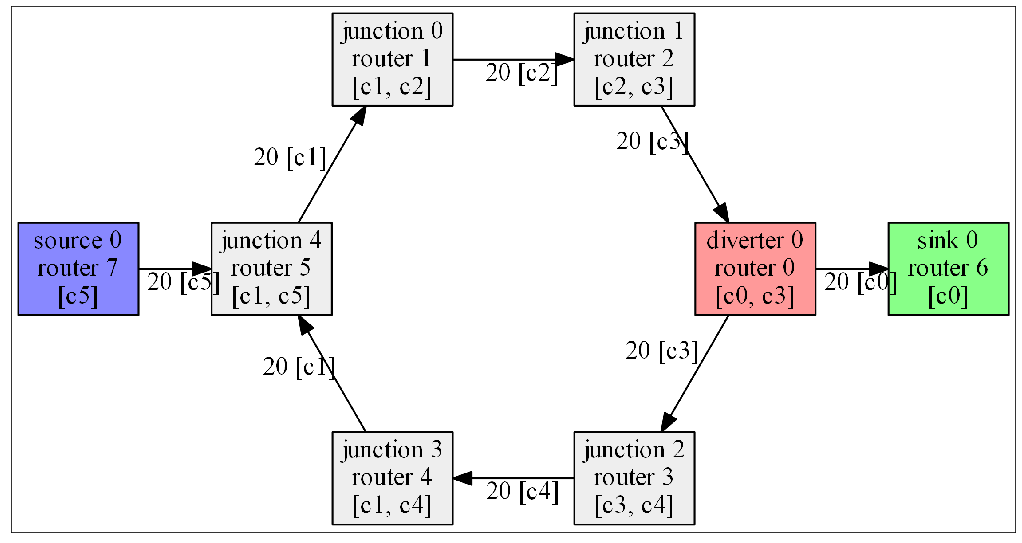

In [4]:
gv_graph = g.to_graphviz()
prefix = "../img/graph."
gv_graph.write(prefix + "gv")
for path in [prefix + "png", prefix + "pdf"]:
    gv_graph.draw(path, prog="circo", args="-Gdpi=300 -Gmargin=0 -Grankdir=LR")
fig, ax = plt.subplots(figsize=(18, 18))
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.imshow(plt.imread(prefix + "png"));

### Test routing from each source to each sink (with argmax choices)

* At junctions, there are routers that do not have choice
* Other routeres are at diverters and they have only two choices
* Argmax choices are unrealistic: during the real system operation, routeres behave stochastically

In [5]:
for source in g.sources:
    for sink in g.sinks:
        print(f"Testing delivery from {source} to {sink}...")
        current_node = source
        visited_nodes = set()
        sink_embedding, _, _ = g.node_to_embeddings(sink, sink)
        while True:
            if current_node in visited_nodes:
                print("    FAIL due to cycle")
                break
            visited_nodes.add(current_node)
            print("    in:", current_node)
            if current_node[0] == "sink":
                print("    ", end="")
                print("OK" if current_node == sink else "FAIL due to wrong destination")
                break
            elif current_node[0] in ["source", "junction"]:
                out_nodes = g.get_out_nodes(current_node)
                assert len(out_nodes) == 1
                current_node = out_nodes[0]
            elif current_node[0] == "diverter":
                current_embedding, neighbors, neighbor_embeddings = g.node_to_embeddings(current_node, sink)
                q_values = []
                for neighbor, neighbor_embedding in zip(neighbors, neighbor_embeddings):
                    with torch.no_grad():
                        q = g.q_forward(current_embedding, sink_embedding, neighbor_embedding).item()
                    print(f"        Q({current_node} -> {neighbor} | {sink}) = {q:.4f}")
                    q_values += [q]
                best_neighbor_index = np.argmax(np.array(q_values))
                current_node = neighbors[best_neighbor_index]
            else:
                raise AssertionError()

Testing delivery from ('source', 0) to ('sink', 0)...
    in: ('source', 0)
    in: ('junction', 4)
    in: ('junction', 0)
    in: ('junction', 1)
    in: ('diverter', 0)
        Q(('diverter', 0) -> ('junction', 2) | ('sink', 0)) = -74.6251
        Q(('diverter', 0) -> ('sink', 0) | ('sink', 0)) = -62.5796
    in: ('sink', 0)
    OK
